# Modlling for engagement 

now we have the features and the lables, we are ready for modelling 
- Classification vs regression
- 9 vs 5 vs 3 scales lables 
- 2.5 vs 5 s window (as is features, average featuers and concatenate features)
- Two-stream Fusion on RGB + Flow 

This should be done over:
- different network artchictures
- cross different familys cross-validation 

Later on:
- Handcrafted features 

### imports and vars

In [1]:
import sys
import numpy as np
import os
import pandas as pd
import itertools
import pickle
import warnings
from pickle import dump
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import logging, sys
logging.disable(sys.maxsize)

import smote_variants as sv
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# import ConfigSpace as CS
# import ConfigSpace.hyperparameters as CSH

# from hpbandster.core.worker import Worker
# from hpbandster.optimizers import BOHB as BOHB
# import hpbandster.core.nameserver as hpns
# import hpbandster.core.result as hpres

import tensorflow_addons as tfa

lables_path = './labels/'
features_path = './features/'
results_path = './modelling_results/'

### help functions 


In [2]:
def load_sub_dataset(familiesSet, label_folder, feature_folder, featureType):
    # append all rows of subjects, and their lables
    allFrames = np.array([])
    allLables = np.array([])

    for this_family in familiesSet:
        # F10_Interaction_1_P27_rgb.npy
        onlyfiles = [f for f in os.listdir(feature_folder) if
                       os.path.isfile(os.path.join(feature_folder, f))
                       and f.startswith(this_family + '_')]
        onlyfiles.sort()

        for this_file in onlyfiles:
            currData = np.load(os.path.join(feature_folder,this_file))            
            substr = '_'.join(this_file.split('_')[4:])
            this_lable_file = this_file.replace('_'+substr,'')+'.npy'
            currLabel = np.load(os.path.join(label_folder,this_lable_file))
            cutoff = min(len(currData), len(currLabel))
            currData = currData[:cutoff,:]
            currLabel =currLabel[:cutoff]
            
            
            if allFrames.shape[0] ==0:
                allFrames = currData
                allLables = currLabel
            else:
                allFrames = np.vstack((allFrames, currData))
                allLables = np.hstack((allLables, currLabel))

    return allFrames, allLables

    
def deploy_modlling(label_folder,feature_folder,shared_directory, prblemType, featureType, num_classes, confID):    
    # repeat experiment
    temp = {}
    all_Subjs = ['F' + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 17]]
    classType = os.path.basename(shared_directory)
    scaler = pickle.load(open(os.path.join(shared_directory,'scaler.pkl'), 'rb'))
    
    X, y = load_sub_dataset(all_Subjs, label_folder, feature_folder, featureType)
    X = scaler.transform(X)
    print(Counter(y))
                 
    # one hot encode y
    trainy = tf.keras.utils.to_categorical(y,  num_classes=num_classes)
    print(trainy[y==0][0])
    print(trainy[y==1][0])
    print(trainy[y==-1][0])
    
    
    model_path = os.path.join(shared_directory,confID)
    print('loading model: ',model_path)
    model = keras.models.load_model(model_path,)
    
    score = model.evaluate(X, trainy, verbose=0)
    predictions = model.predict(X)
    
    return score, predictions



### modeling handcrafted 

In [3]:
prblemTypes = ['classification']
featureTypes = ['handcrafted_extra']
classes = [3]
fusionTypes = ['5s']
sampling_methods = ['polynom_fit_SMOTE']

permutations=[ prblemTypes, featureTypes, classes, fusionTypes]
all_permutations = list(itertools.product(*permutations))
print(len(all_permutations))
for this_permutation in all_permutations:
    round_num = '1'
    confID = '(0, 0, 6)'
    
    (prblemType, featureType, eng_lvls, fusionType) = this_permutation
    classType = 'round_avg_eng_level' if prblemType == 'classification' else 'avg_eng_level'

    
    print('Working on: ',prblemType, featureType, eng_lvls, fusionType)
    
    label_folder = os.path.join(lables_path,'_'.join([classType,'eng_lvl',prblemType,str(eng_lvls),str(fusionType)]))
    feature_folder = os.path.join(features_path,'_'.join([featureType,'features',fusionType]))
    
    for sampling_method in sampling_methods:
        result_folder = os.path.join(results_path,'_'.join([featureType,prblemType,
                                                            str(eng_lvls),fusionType,sampling_method,'final',round_num]))

    score, predictions = deploy_modlling(label_folder,feature_folder,result_folder, prblemType, featureType, eng_lvls, confID)#, divide,fusionType)


1
Working on:  classification handcrafted_extra 3 5s
Counter({1.0: 9183, 0.0: 1574, -1.0: 195})
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
loading model:  ./modelling_results/handcrafted_extra_classification_3_5s_polynom_fit_SMOTE_final_1/(0, 0, 6)


2021-11-25 23:16:08.511855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 23:16:08.514695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sharifa/catkin_ws/devel/lib:/usr/local/cuda-11.0/lib64
2021-11-25 23:16:08.515068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sharifa/catkin_ws/devel/lib:/usr/local/cuda-11.0/lib64
2021-11-25 23:16:08.515078: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned ab

In [4]:
the_columns = ['thisloss','tp','fp','tn','fn','acc','prec','rec','auc','BC','MCC']
resultsDF = pd.DataFrame([score],columns=the_columns,index=["score"],)
resultsDF

,thisloss,tp,fp,tn,fn,acc,prec,rec,auc,BC,MCC
score,0.063705,10779.0,171.0,21733.0,173.0,0.98953,0.984384,0.984204,0.996935,0.563511,0.942382


In [5]:
np.argmax(predictions, axis=1)

array([1, 0, 0, ..., 0, 1, 0])

In [6]:
predictions.round()

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [7]:

Counter(np.argmax(predictions, axis=1))

Counter({1: 9271, 0: 1479, 2: 202})

In [8]:
# Counter({1.0: 9183, 0.0: 1574, -1.0: 195})
# Counter({1: 9271, 0: 1479, 2: 202})
print(9183+1574+195)
print(9271+1479+202)

10952
10952


In [9]:
# predictions[np.argmax(predictions, axis=1)==2].round()

In [10]:
from sklearn.metrics import confusion_matrix

In [15]:
all_Subjs = ['F' + str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 17]]

prblemType, featureType, eng_lvls, fusionType = 'classification','handcrafted_extra',3,'5s'
sampling_method = 'polynom_fit_SMOTE'
classType = 'round_avg_eng_level' if prblemType == 'classification' else 'avg_eng_level'
    
result_folder = os.path.join(results_path,'_'.join([featureType,prblemType,
                                                            str(eng_lvls),fusionType,sampling_method,'final',round_num]))

label_folder = os.path.join(lables_path,'_'.join([classType,'eng_lvl',prblemType,str(eng_lvls),str(fusionType)]))
feature_folder = os.path.join(features_path,'_'.join([featureType,'features',fusionType]))

classType = os.path.basename(result_folder)
X, y_true = load_sub_dataset(all_Subjs, label_folder, feature_folder, featureType)

y_true[y_true==-1]=2
y_pred = np.argmax(predictions, axis=1)

In [16]:
confusion_matrix(y_true, y_pred)

array([[1442,  128,    4],
       [  37, 9143,    3],
       [   0,    0,  195]])

In [17]:
sum(confusion_matrix(y_true, y_pred))

array([1479, 9271,  202])

In [18]:
sum(sum(confusion_matrix(y_true, y_pred)))

10952

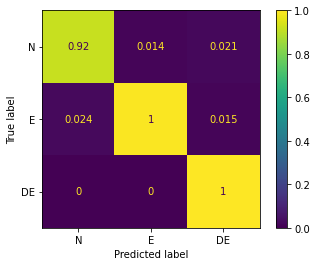

In [26]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

classes_ = np.array([0,1,2])
classes_neame = np.array(['N','E','DE'])
cm = confusion_matrix(y_true, y_pred, labels=classes_)
cm = cm / cm.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes_neame)
disp.plot()

plt.show()